# 各种常用sklearn算法实践特性分析

# 算法综合比较

在实际的应用中，数据必然存在大量的缺失值，因此能否处理缺失值，是算法可应用性的关键。

LGB、XGB可以自动处理缺失值，并把缺失值转化成特征。

其他的算法处理缺失值能力都不强：

- lr
- mlp
mlp的输入必须是数值型的，因此很不适合。


实际问题中，

- 要么数据少，可提取的信息太少
- 要么数据太大，且前后分布有漂移，要避免过拟合

因此，好的算法应该既能在数据量少的时候保持基本的性能，又能在数据量大的时候避免过拟合。
LGB在这两方面都是很好的。



# 1. LR

## 特点分析

- 优点：
    - 实现简单，需要配置的超参数少
    - 训练速度快，支持多线程
- 缺点：
    - 模型的复杂度低，且无法通过超参数增大复杂度
    - 对复杂的分类问题，很难达到非常高的分类性能
    
LR非常适合在不做任何配置的情况下做**baseline**，其他的复杂模型与LR baseline性能相比的增益才是有意义的。 

## solver选择

LR默认的优化求解器，不适用于大数据集，需要手动设置为solver='lbfgs'。
不同solver的速度差别：

- Liblinear，当前的默认solver，不支持多线程
- lbfgs，后续版本的默认solver

|训练数据量| Liblinear  | lbfgs |
|--|--|--|
| 1w | 6.97 | 9.3 |
|10w| 105s | 7.8s|

在数据量小的时候，可以使用默认的Liblinear，一旦数据量增大，必须切换到lbfgs，才能快速求解。



In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state = 0, verbose=1, solver='lbfgs', n_jobs=-1)

# LightGBM


优点：

- 自动处理null，归一化，很多情况下比手动处理的更好
不用手动进行One-hot编码
- 速度和内存使用的优化
- 并行支持GPU
- 通过subsample下采样，降低过拟合

## FeaturesBundling

稀疏数据存在大量0值或者空值，从特征组合的角度来看，稀疏意味着某些features不会同时出现。

> ome features are never non-zero together. 
For instance, the words “Python” and “protein” might never appear in the same document in the data. 

这意味着多个特征可以Bundling成为一个特征，且不损失信息。

具体的实现没有说明。


In [ ]:
dtrain = lgb.Dataset(X_train, label=Y_train)
dtest = lgb.Dataset(X_test, label=Y_test)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',   # 二分类
    'metric': 'auc',         # auc, binary_loss, cross_entropy
    'min_child_weight': 1.5, # 避免过拟合
    'num_leaves': 2 ** 5,    # 32
    'lambda_l2': 10,         # 正则化系数
    'subsample': 0.85,       # 降采样
    'learning_rate': 0.1,
    'seed': 2018,
    'boosting': 'dart',     # Better Accuracy,Dropouts meet Multiple Additive Regression Trees
    'colsample_bytree': 0.5, # 特征降采样
    'save_binary': True,     # binary IO faster
    'nthread': -1            # 多进程并行
}
model = lgb.train(params, dtrain, 
                  num_boost_round=2000, 
                  valid_sets=dtest, 
                  early_stopping_rounds=50,
                  verbose_eval=200)
#y_pred_prob = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)



http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/

LGB和XGB的实现机制：

- 决策树采用leaf-wise生长策略
Level-wise策略下，决策树是平衡的；leaf-wise的决策树不要求枝叶平衡，只关注loss最小。
leaf-wise more prone to overfitting but is more flexible，对于大数据集是更合适的。
- 采用直方图（Histogram）训练
即训练采用的不是原始的数据，而是切分bin之后的直方图，原理在于：
> small changes in the split don’t make much of a difference in the performance

即放弃了绝对精确的划分，追求速度上的平衡。
- 稀疏数据处理Ignoring sparse inputs
由于系数数据中存在大量的0 feature，在计算split的时候，不考虑0 features；
在找到split之后，再将0 features划分到使得loss更小的一侧。此为一种有效的简化处理。
- Subsampling数据下采样
既有在row层面的下采样，也有在feature col的下采样。
隐含的原理是，不同的数据、特征对模型的贡献不同的。例如梯度变化越大的特征，区分度可能越高，反之越低。
> not all data points contribute equally to training
- FeaturesBundling
考虑了稀疏特征的组合特性，具体是实现不详。

启示：

- 采用XGB和LGB足够了，没有必要再用原生的GBDT做对比。
- 调参可以考虑从这些角度来提升模型的性能


# 交叉验证方法

K折交叉验证的优势：

- 在没有测试集GT的情况下，可以更准确地评估模型的性能
- 避免手动切分训练集和验证集，造成对训练集过拟合
- 对k折的test predict结果去平均作为最终输出

实现方式：

- 用`KFold`划分训练集和验证集的index，手动写循环
可以在循环中依次predict test结果，得到均值作为输出
- 如果只需要模型在验证集上的score，可以直接用cross_val_score实现

In [ ]:
# KFold实现
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# Create the kfold object
k_fold = KFold(n_splits = 3, shuffle = True, random_state = 50)

def run_cv(clf):
    '''
    - clf，典型的sklearn分类器，具有fit/predict_proba 方法
    - submission，输出的k折平均的测试集结果
    '''
    # 用于记录各轮的测试集分数,验证集score
    test_prob = np.zeros(test_fill.shape[0])
    val_scores = []
    
    for idx_train, idx_val in k_fold.split(train):
        X_train, y_train = train[idx_train], train_labels[idx_train]
        X_val, y_val = train[idx_val], train_labels[idx_val]
        clf.fit(X_train, y_train)
        val_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
        val_scores.append(val_score)
        test_prob += model.predict_proba(test_data)[:, 1] / k_fold.n_splits

    submission = pd.DataFrame({'ID': test_ids, 'TARGET': test_prob})
    print('mean val score: {}'.format(np.mean(val_scores)))
    return submission

submission = run_cv(clf)

# 用StratifiedKFold 实现
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
# 返回的 scores 是各类val分数的list
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Baseline 性能对比

HomeCredit，用特征工程之后的数据，评测lgb最优模型与其他baseline分类器的性能差异。

数据说明：

- data_fe，特征工程生成的数据
- data_fill，填充null，处理极大值之后的数据

由于LGB可以直接输入带null的数据，而其他分类器需要对填充null，故统一用填充处理后的data_fill评测。

评测结果：各个分类器的auc指标很低，最高仅为0.584。而使用data_fe训练的val auc在0.78。

|    clf      |   test_score |   val_score |
|:------------|-------------:|------------:|
| lgbm_tune   |    nan       |    0.58447  |
| lgbm_base   |    nan       |    0.5642   |
| xgb         |    nan       |    0.54     |
| lr_baseline |      0.54191 |    0.516605 |
| mlp_32      |      0.5284  |    0.5142   |


观点：

- 强制imputer可能给数据带来了不利的噪音，例如大量的null用median填充，对于null比例很高的col，不合理
- 总体上，lgb的学习能力是强于其他model。

数据imputer的方法如下：

In [ ]:
def impute_inf(df_data):
    imputer = Imputer(strategy = 'median')
    # replace inf as nan
    df_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # impute nan to median
    df_data = imputer.fit_transform(df_data)
    return df_data

train_fill = impute_inf(train)

# lgb

lgb对nan数据处理的机制是什么



- 确认LGB对nan数据的处理方法
- 验证数据归一化是否为影响指标的主要因素
- GBDT方法在预测阶段如何处理残差

# LGB对Missing Value的处理方法

tabular data是向量化的，必然存在大量的缺失值，是稀疏的。
尤其在featuresTools跨表格生成特征之后，必然伴随着大量的缺失值。

LGB和XGB对缺失值的处理方法是一致的：

- LGB默认use_missing=True（把缺失值当做0处理）
- 在计算split的时候，不考虑0 features
- 在找到split之后，再将0 features划分到使得loss更小的一侧
> then allocating all the data with missing values to whichever side of the split reduces the loss more.

参考：http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/

LGB处理缺失值的规则：

- 默认use_missing=True处理缺失值，可以通过设置use_missing = false 来使其无效。
- 默认的方式用NA（NaN）去表示缺失值
    - 当设置zero_as_missing = false（默认）时，在稀疏矩阵里（和lightSVM），没有显示的值视为0
    - 当设置zero_as_missing = true时，NA和0（包括在稀疏矩阵里，没有显示的值）视为缺失。
参考：https://github.com/Microsoft/LightGBM/blob/master/docs/Advanced-Topics.rst


总结：在XGB和LGB中，缺失值本身可以可以作为特征的一部分。手动imputer反而可能影响性能。

# Grid Search

**GridSearchCV**

注意：

- 可配置的参数获取
`pipe_svc.get_params`
- scoring='accuracy'
其他可用的score参见：https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
分类任务常用的有：accuracy/f1/roc_auc
- `clf = gs.best_estimator_` 得到调参的最优模型


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))


# 自定义scorer

利用make_scorer 自定义。

```
from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score, pos_label=0)
scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
```



# mlxtend plot

## 数据类别可视化

有助于快速观察类别分布

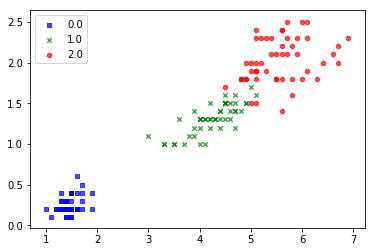

In [6]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter

iris = datasets.load_iris()
# convert iris to df
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                  columns= iris['feature_names'] + ['target'])
fig = category_scatter(x=2, y=3, label_col=4, 
                       data=df.values, legend_loc='upper left')

## 决策区域可视化

对于2D输入，可以直观看到。

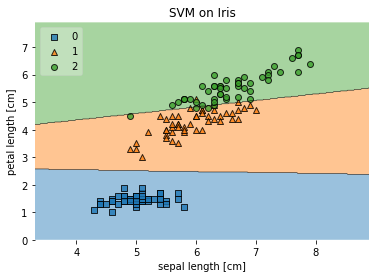

In [8]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)


# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')
plt.show()

# bagging 与voting 的关系是什么呢？

可以测试一下bagging 与voting的关系是什么

可以走通mlx的 决策图